In [1]:
import os
import torch
import torchvision
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from torchvision import transforms, models
from torch.utils.data import DataLoader, Dataset

In [2]:
class DogDataset(Dataset):
    def __init__(self, image_folder, transform=None):
        valid_extensions = ('.png', '.jpg', '.jpeg')  # Supported image formats
        self.image_paths = []

        # Walk through all subdirectories
        for root, _, files in os.walk(image_folder):
            for file in files:
                if file.lower().endswith(valid_extensions):  # Filter valid image files
                    self.image_paths.append(os.path.join(root, file))

        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, img_path

**Defining Image Transformations and
Resize to 224×224**

Normalize using ImageNet mean and standard deviation.

In [3]:
# Define Image Transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    # Converting images to PyTorch tensors
    transforms.ToTensor(),
    # Normalizing using ImageNet stats
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [4]:
# Mounting Google Drive and Load Dataset
from google.colab import drive
drive.mount('/content/drive')

# Path to the dataset folder in your Google Drive
image_folder = '/content/drive/My Drive/Images'

# Creating the dataset and dataloader
dataset = DogDataset(image_folder, transform=transform)
dataloader = DataLoader(dataset, batch_size=1, shuffle=False)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
# Verify the dataset
print(f"Total Images Found: {len(dataset)}")

# Checking the first batch from the dataloader
for images, paths in dataloader:
    print(f"First Image Path: {paths[0]}")
    print(f"Image Tensor Shape: {images.shape}")
    break

Total Images Found: 627
First Image Path: /content/drive/My Drive/Images/n02102318-cocker_spaniel/n02102318_10019.jpg
Image Tensor Shape: torch.Size([1, 3, 224, 224])


### **Loading Pretrained ResNet18 Model**

In [6]:
# Loading ResNet18 Model
resnet18 = models.resnet18(pretrained=True)
resnet18.eval()  # Setting the model to evaluation mode

# Removing fully connected layers to extract features from the last convolutional layer
feature_extractor = torch.nn.Sequential(*list(resnet18.children())[:-2])

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


**Reference**

The feature extraction process from the last convolutional layer of ResNet18 is inspired by the blog tutorial:
* https://kozodoi.me/blog/20210527/extracting-features

### Extracting Features from Images

In [7]:
# Step 7: Extract Features from Images
features = []
image_paths = []

print("Extracting features...")
for i, (images, paths) in enumerate(dataloader):
    with torch.no_grad():
        output = feature_extractor(images)  # Extract features
        extracted_feature = output.squeeze().numpy()  # Convert to NumPy array

        features.append(extracted_feature)
        image_paths.append(paths[0])

        # Print details for the first 2 images
        if i < 2:
            print(f"Image Path: {paths[0]}")
            print(f"Extracted Feature Shape: {extracted_feature.shape}")
            print(f"Feature Sample (first 5 values): {extracted_feature.flatten()[:5]}")

print(f"Total Features Extracted: {len(features)}")

Extracting features...
Image Path: /content/drive/My Drive/Images/n02102318-cocker_spaniel/n02102318_10019.jpg
Extracted Feature Shape: (512, 7, 7)
Feature Sample (first 5 values): [1.5302961 2.9189868 4.0315266 3.684019  3.2587147]
Image Path: /content/drive/My Drive/Images/n02102318-cocker_spaniel/n02102318_10087.jpg
Extracted Feature Shape: (512, 7, 7)
Feature Sample (first 5 values): [0.        0.        0.8879666 1.4956644 2.2210228]
Total Features Extracted: 627


In [8]:
# Step 8: Saving Extracted Features
import pickle
output_file = '/content/drive/My Drive/extracted_features.pkl'
with open(output_file, 'wb') as f:
    pickle.dump({'features': features, 'image_paths': image_paths}, f)

print(f"Features saved successfully to {output_file}")

Features saved successfully to /content/drive/My Drive/extracted_features.pkl


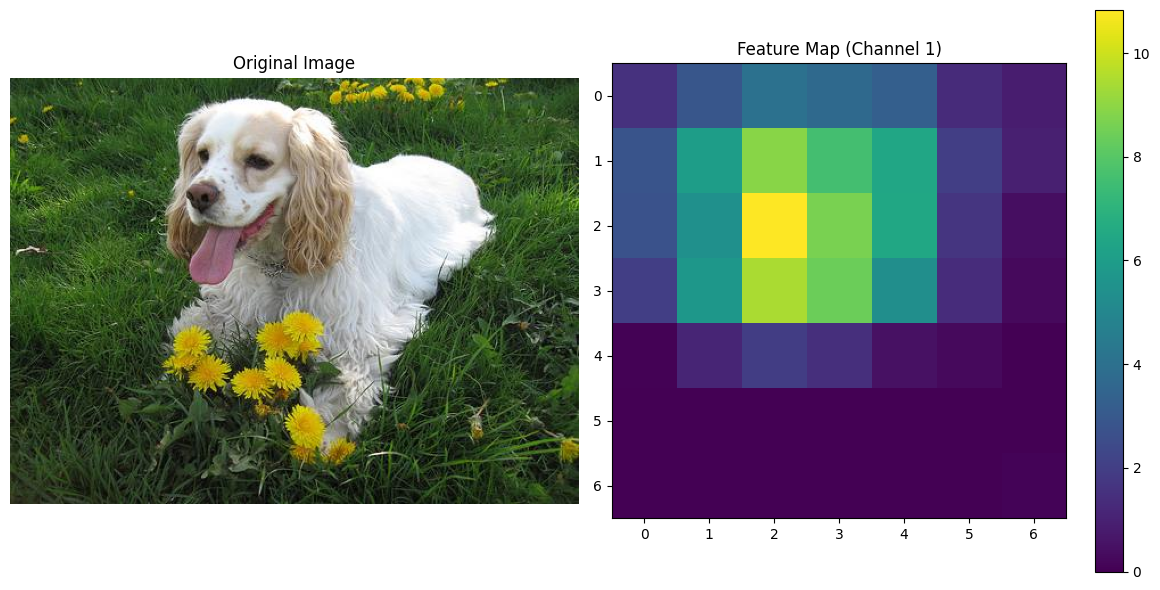

In [9]:
first_image_path = image_paths[0]
first_image = Image.open(first_image_path).convert('RGB')

first_feature = features[0]
feature_map = first_feature[0]
# Creating a side-by-side plot
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
# Plot the original image
axes[0].imshow(first_image)
axes[0].axis('off')
axes[0].set_title("Original Image")

# Ploting the feature map
im = axes[1].imshow(feature_map, cmap='viridis')
axes[1].set_title("Feature Map (Channel 1)")
plt.colorbar(im, ax=axes[1])

plt.tight_layout()
plt.show()

### Dimension Reduction Using PCA

In [10]:
from sklearn.decomposition import PCA

# Loading features and image paths from the saved .pkl file
with open('/content/drive/My Drive/extracted_features.pkl', 'rb') as f:
    data = pickle.load(f)

features = data['features']  # List of feature arrays
image_paths = data['image_paths']  # List of image paths

# If the feature shape is (C, H, W), flatten it to (C * H * W)
flattened_features = [f.flatten() for f in features]

# Convert to a NumPy array for PCA
flattened_features = np.array(flattened_features)

print(f"Original Feature Shape: {flattened_features.shape}")

# Step 3: Apply PCA to Reduce Dimensions
pca = PCA(n_components=2)
reduced_features = pca.fit_transform(flattened_features)

print(f"Reduced Feature Shape: {reduced_features.shape}")

# Step 4: Save Reduced Features
output_reduced_file = '/content/drive/My Drive/reduced_features.pkl'
with open(output_reduced_file, 'wb') as f:
    pickle.dump({'reduced_features': reduced_features, 'image_paths': image_paths}, f)

print(f"Reduced features saved successfully to {output_reduced_file}")

Original Feature Shape: (627, 25088)
Reduced Feature Shape: (627, 2)
Reduced features saved successfully to /content/drive/My Drive/reduced_features.pkl


####**Visualizing the reduced features in a 2D scatter plot to confirm successful dimensionality reduction.**

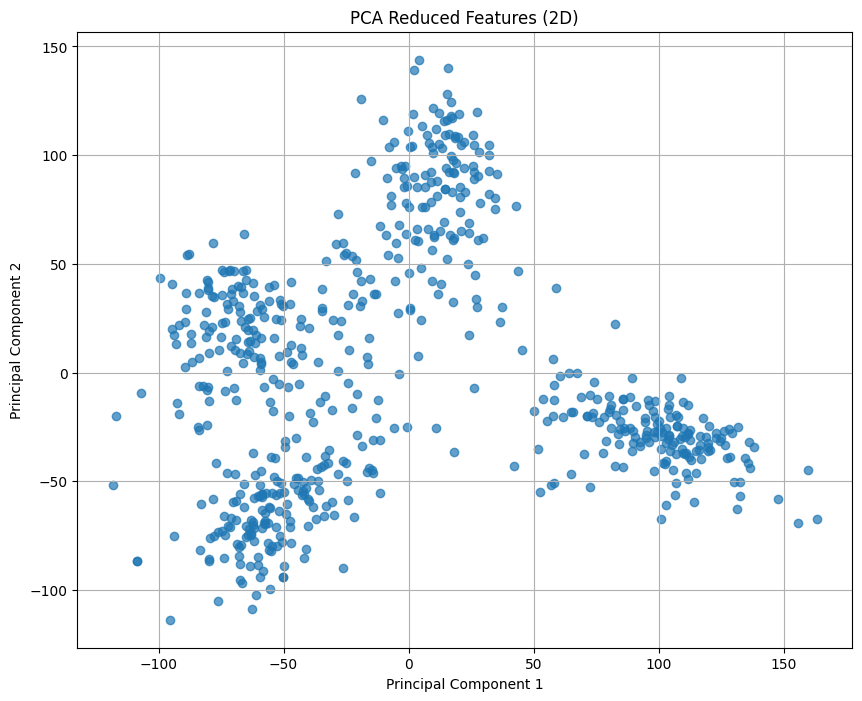

In [11]:
# Ploting reduced features
plt.figure(figsize=(10, 8))
plt.scatter(reduced_features[:, 0], reduced_features[:, 1], alpha=0.7)
plt.title('PCA Reduced Features (2D)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True)
plt.show()

In [12]:
from sklearn.cluster import KMeans, SpectralClustering
from sklearn.cluster import BisectingKMeans
import pickle

# Loading 2D Reduced Dataset
with open('/content/drive/My Drive/reduced_features.pkl', 'rb') as f:
    data = pickle.load(f)

reduced_features = data['reduced_features']
image_paths = data['image_paths']

def plot_clusters(data, labels, title):
    plt.figure(figsize=(8, 6))
    plt.scatter(data[:, 0], data[:, 1], c=labels, cmap='viridis', s=50, alpha=0.8)
    plt.title(title)
    plt.xlabel("Dimension 1")
    plt.ylabel("Dimension 2")
    plt.colorbar()
    plt.show()

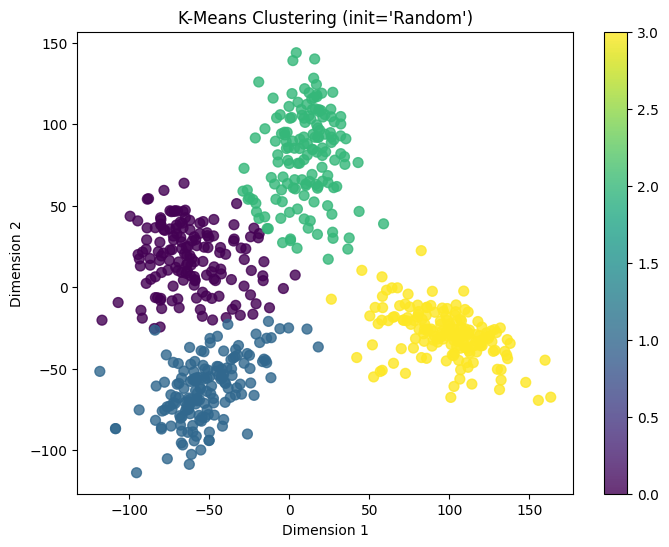

In [13]:
# K-Means Clustering (init='Random')
kmeans_random = KMeans(n_clusters=4, init='random', random_state=42)
labels_kmeans_random = kmeans_random.fit_predict(reduced_features)
plot_clusters(reduced_features, labels_kmeans_random, "K-Means Clustering (init='Random')")

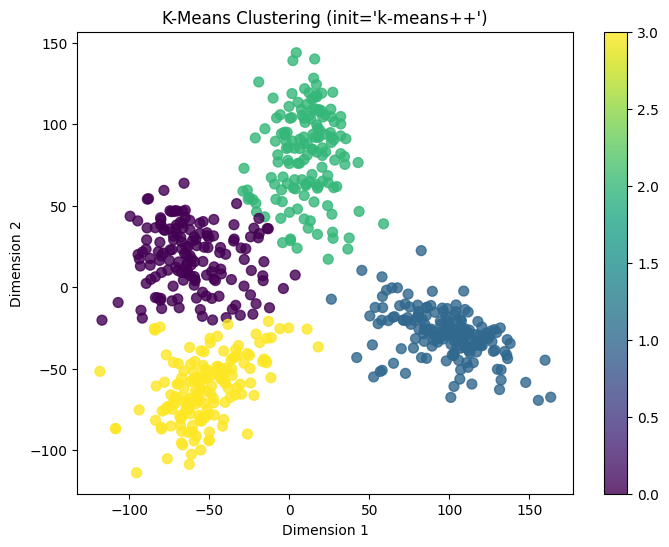

In [14]:
# K-Means Clustering (init='k-means++')
kmeans_plus = KMeans(n_clusters=4, init='k-means++', random_state=42)
labels_kmeans_plus = kmeans_plus.fit_predict(reduced_features)
plot_clusters(reduced_features, labels_kmeans_plus, "K-Means Clustering (init='k-means++')")

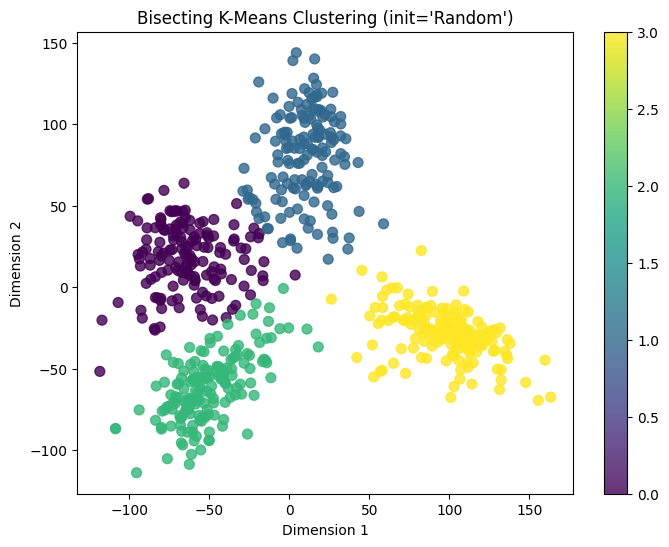

In [15]:
# Bisecting K-Means (init='Random')
bisecting_kmeans = BisectingKMeans(n_clusters=4, init='random', random_state=42)
labels_bisecting_kmeans = bisecting_kmeans.fit_predict(reduced_features)
plot_clusters(reduced_features, labels_bisecting_kmeans, "Bisecting K-Means Clustering (init='Random')")

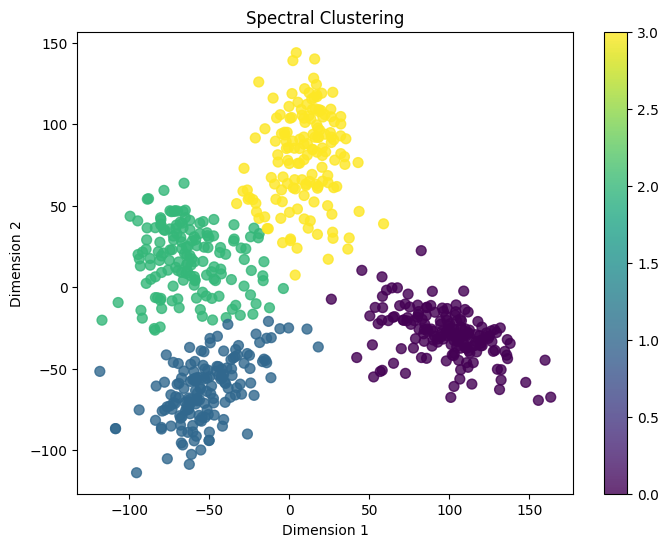

In [16]:
# Spectral Clustering
spectral_clustering = SpectralClustering(n_clusters=4, random_state=42, affinity='nearest_neighbors')
labels_spectral = spectral_clustering.fit_predict(reduced_features)
plot_clusters(reduced_features, labels_spectral, "Spectral Clustering")

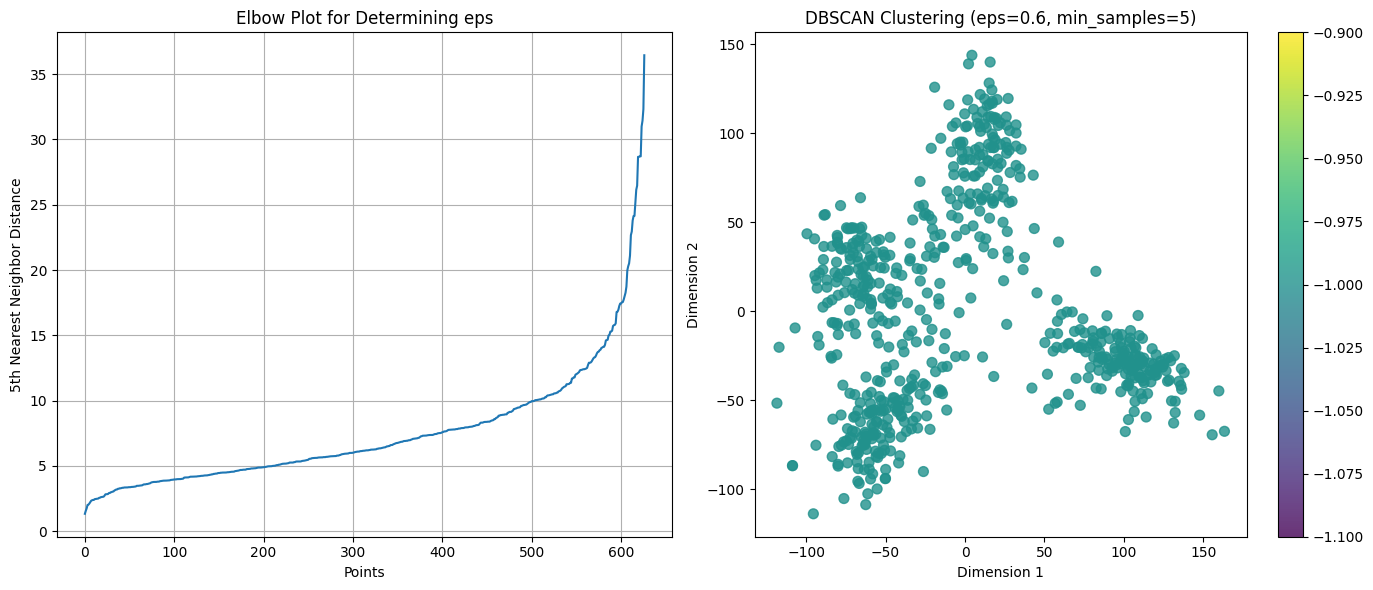


Parameters used:
- eps: 0.6
- min_samples: 5
Result: DBSCAN successfully formed 0 clusters.



In [17]:
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors

# Step 1: Find Optimal Epsilon (eps) using NearestNeighbors
neighbors = NearestNeighbors(n_neighbors=5)  # Use min_samples=5 as an initial value
neighbors_fit = neighbors.fit(reduced_features)
distances, indices = neighbors_fit.kneighbors(reduced_features)

distances = np.sort(distances[:, 4])  # Using the 5th nearest neighbor
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot Elbow Curve
axes[0].plot(distances)
axes[0].set_title("Elbow Plot for Determining eps")
axes[0].set_xlabel("Points")
axes[0].set_ylabel("5th Nearest Neighbor Distance")
axes[0].grid()

# Step 2: Apply DBSCAN with chosen eps and min_samples
eps = 0.6  # Adjust based on the elbow plot
min_samples = 5  # Minimum number of samples in a neighborhood
dbscan = DBSCAN(eps=eps, min_samples=min_samples)
labels_dbscan = dbscan.fit_predict(reduced_features)

# Visualize DBSCAN Clusters
scatter = axes[1].scatter(reduced_features[:, 0], reduced_features[:, 1], c=labels_dbscan, cmap='viridis', s=50, alpha=0.8)
axes[1].set_title(f"DBSCAN Clustering (eps={eps}, min_samples={min_samples})")
axes[1].set_xlabel("Dimension 1")
axes[1].set_ylabel("Dimension 2")
fig.colorbar(scatter, ax=axes[1])

plt.tight_layout()
plt.show()

# report
print(f"""
Parameters used:
- eps: {eps}
- min_samples: {min_samples}
Result: DBSCAN successfully formed {len(set(labels_dbscan)) - (1 if -1 in labels_dbscan else 0)} clusters.
""")


### **Agglomerative Clustering** with number of clusters set to 4

In [18]:
from sklearn.cluster import AgglomerativeClustering

def perform_agglomerative_clustering(data, linkage, title):
    clustering = AgglomerativeClustering(n_clusters=4, linkage=linkage)
    labels = clustering.fit_predict(data)

    # Plotting results
    plt.figure(figsize=(8, 6))
    plt.scatter(data[:, 0], data[:, 1], c=labels, cmap='viridis', s=50, alpha=0.8)
    plt.title(title)
    plt.xlabel("Dimension 1")
    plt.ylabel("Dimension 2")
    plt.colorbar(label="Cluster")
    plt.grid()
    plt.show()

### **a. Single link (MIN)**
REPORT: Clusters appear elongated and loosely connected. Single Link tends to chain points together, forming long, sparse clusters.

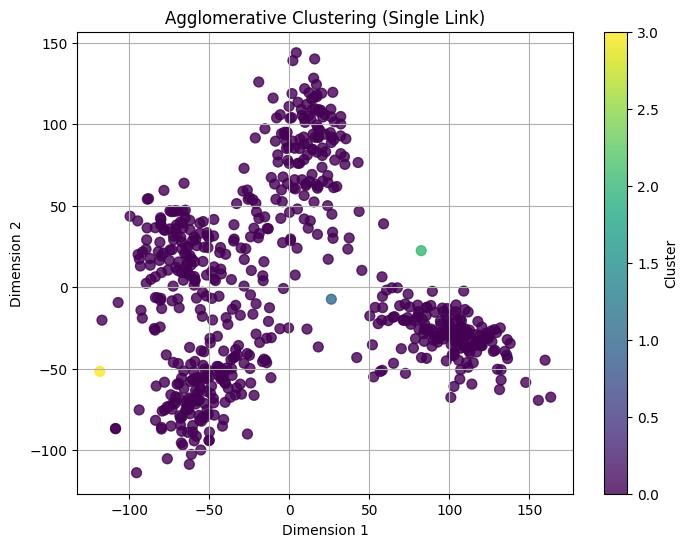

In [19]:
# (a) Single Link (MIN)
perform_agglomerative_clustering(reduced_features, linkage='single', title="Agglomerative Clustering (Single Link)")

### **b. Complete Link (MAX)**
Clusters are more compact and tightly bound compared to Single Link. However, this method may exaggerate separation between clusters that are close.

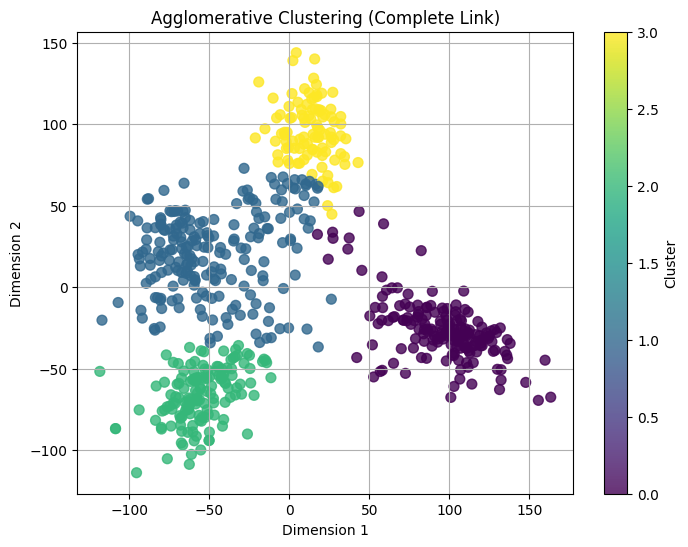

In [20]:
# (b) Complete Link (MAX)
perform_agglomerative_clustering(reduced_features, linkage='complete', title="Agglomerative Clustering (Complete Link)")

### **c. Group Average**
Report: Clusters are relatively balanced. Group Average tends to merge clusters with moderate distances, producing fairly well-distributed clusters.

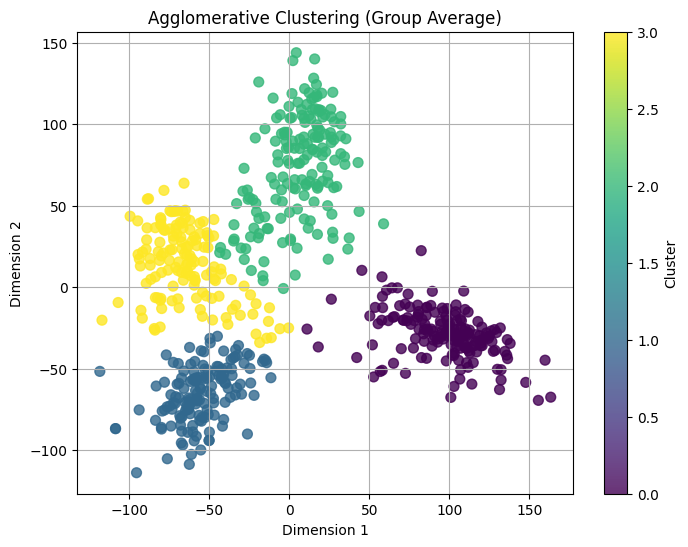

In [21]:
# (c) Group Average
perform_agglomerative_clustering(reduced_features, linkage='average', title="Agglomerative Clustering (Group Average)")

### **d. Ward's Method**
Report: Clusters are tight, compact, and well-separated. Ward’s method minimizes within-cluster variance, producing the most visually distinct clusters.

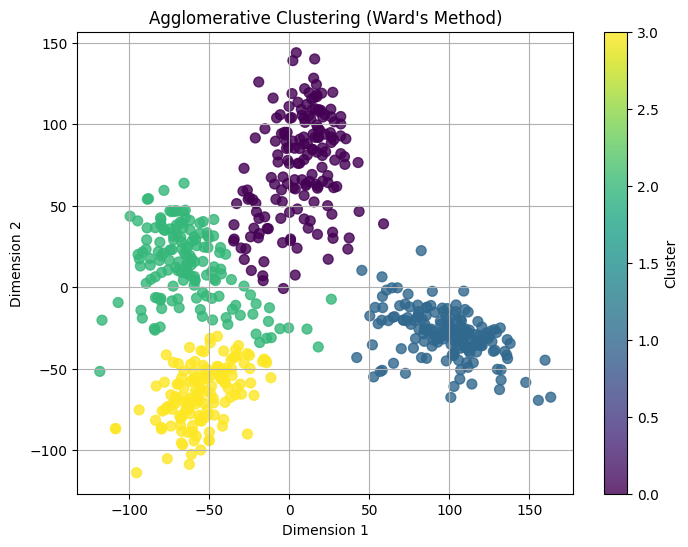

In [22]:
# (d) Ward’s Method
perform_agglomerative_clustering(reduced_features, linkage='ward', title="Agglomerative Clustering (Ward's Method)")

In [23]:
from sklearn.metrics import fowlkes_mallows_score
from sklearn.cluster import KMeans, SpectralClustering, AgglomerativeClustering, DBSCAN
from sklearn.cluster import BisectingKMeans
from sklearn.preprocessing import LabelEncoder

image_folder = '/content/drive/My Drive/Images'

# Generating true labels from subfolder names
true_labels = []
for root, dirs, files in os.walk(image_folder):
    for file in files:
        if file.lower().endswith(('.png', '.jpg', '.jpeg')):
            # Use the subfolder name as the label
            label = os.path.basename(root)
            true_labels.append(label)

# Converting labels to numeric format
label_encoder = LabelEncoder()
true_labels = label_encoder.fit_transform(true_labels)

if len(true_labels) != len(reduced_features):
    raise ValueError(f"Length mismatch: true_labels has {len(true_labels)} samples, "
                     f"but reduced_features has {len(reduced_features)} samples.")

print(f"True Labels Generated: {true_labels[:10]}")  # Showing first 10 labels


True Labels Generated: [0 0 0 0 0 0 0 0 0 0]


In [24]:
fmi_results = {}

# K-Means Clustering Evaluations
# (a) K-Means with init='Random'
kmeans_random = KMeans(n_clusters=4, init='random', random_state=42)
labels_kmeans_random = kmeans_random.fit_predict(reduced_features)
fmi_results['K-Means (Random)'] = fowlkes_mallows_score(true_labels, labels_kmeans_random)

# (b)init='k-means++'
kmeans_plus = KMeans(n_clusters=4, init='k-means++', random_state=42)
labels_kmeans_plus = kmeans_plus.fit_predict(reduced_features)
fmi_results['K-Means (k-means++)'] = fowlkes_mallows_score(true_labels, labels_kmeans_plus)

# (c)init='Random'
bisecting_kmeans = BisectingKMeans(n_clusters=4, init='random', random_state=42)
labels_bisecting_kmeans = bisecting_kmeans.fit_predict(reduced_features)
fmi_results['Bisecting K-Means'] = fowlkes_mallows_score(true_labels, labels_bisecting_kmeans)

# Spectral Clustering Evaluation
spectral_clustering = SpectralClustering(n_clusters=4, random_state=42, affinity='nearest_neighbors')
labels_spectral = spectral_clustering.fit_predict(reduced_features)
fmi_results['Spectral Clustering'] = fowlkes_mallows_score(true_labels, labels_spectral)

# Agglomerative Clustering Evaluations
# (a) Single Link (MIN)
agg_single = AgglomerativeClustering(n_clusters=4, linkage='single')
labels_agg_single = agg_single.fit_predict(reduced_features)
fmi_results['Agglomerative (Single Link)'] = fowlkes_mallows_score(true_labels, labels_agg_single)

# (b) Complete Link (MAX)
agg_complete = AgglomerativeClustering(n_clusters=4, linkage='complete')
labels_agg_complete = agg_complete.fit_predict(reduced_features)
fmi_results['Agglomerative (Complete Link)'] = fowlkes_mallows_score(true_labels, labels_agg_complete)

# (c) Group Average
agg_average = AgglomerativeClustering(n_clusters=4, linkage='average')
labels_agg_average = agg_average.fit_predict(reduced_features)
fmi_results['Agglomerative (Group Average)'] = fowlkes_mallows_score(true_labels, labels_agg_average)

# (d) Ward’s Method
agg_ward = AgglomerativeClustering(n_clusters=4, linkage='ward')
labels_agg_ward = agg_ward.fit_predict(reduced_features)
fmi_results['Agglomerative (Ward)'] = fowlkes_mallows_score(true_labels, labels_agg_ward)

# DBSCAN Evaluation
dbscan = DBSCAN(eps=0.5, min_samples=5)
labels_dbscan = dbscan.fit_predict(reduced_features)
if len(set(labels_dbscan)) > 1:
    fmi_results['DBSCAN'] = fowlkes_mallows_score(true_labels, labels_dbscan)
else:
    fmi_results['DBSCAN'] = "N/A (Failed to cluster)"

# Print FMI Results
print("Fowlkes-Mallows Index Results:")
for method, fmi in fmi_results.items():
    print(f"{method}: {fmi}")

Fowlkes-Mallows Index Results:
K-Means (Random): 0.9364090340921057
K-Means (k-means++): 0.9222469713650447
Bisecting K-Means: 0.9394982967475103
Spectral Clustering: 0.9451208670010148
Agglomerative (Single Link): 0.496829823296963
Agglomerative (Complete Link): 0.7954081172678994
Agglomerative (Group Average): 0.9270261713365169
Agglomerative (Ward): 0.9285160944402231
DBSCAN: N/A (Failed to cluster)


In [25]:
from sklearn.metrics import silhouette_score

silhouette_results = {}

# K-Means Clustering Evaluations
# (a) K-Means with init='Random'
silhouette_results['K-Means (Random)'] = silhouette_score(reduced_features, labels_kmeans_random)

# (b) K-Means with init='k-means++'
silhouette_results['K-Means (k-means++)'] = silhouette_score(reduced_features, labels_kmeans_plus)

# (c) Bisecting K-Means with init='Random'
silhouette_results['Bisecting K-Means'] = silhouette_score(reduced_features, labels_bisecting_kmeans)

# Step 2: Spectral Clustering Evaluation
silhouette_results['Spectral Clustering'] = silhouette_score(reduced_features, labels_spectral)

# Step 3: Agglomerative Clustering Evaluations

silhouette_results['Agglomerative (Single Link)'] = silhouette_score(reduced_features, labels_agg_single)

# (MAX)
silhouette_results['Agglomerative (Complete Link)'] = silhouette_score(reduced_features, labels_agg_complete)

# Group Average
silhouette_results['Agglomerative (Group Average)'] = silhouette_score(reduced_features, labels_agg_average)

# Ward’s Method
silhouette_results['Agglomerative (Ward)'] = silhouette_score(reduced_features, labels_agg_ward)

# DBSCAN Evaluation
if len(set(labels_dbscan)) > 1:
    silhouette_results['DBSCAN'] = silhouette_score(reduced_features, labels_dbscan)
else:
    silhouette_results['DBSCAN'] = "N/A (Failed to cluster)"

#Silhouette Coefficient Results
print("Silhouette Coefficient Results:")
for method, score in silhouette_results.items():
    print(f"{method}: {score}")


Silhouette Coefficient Results:
K-Means (Random): 0.6050058007240295
K-Means (k-means++): 0.6039947867393494
Bisecting K-Means: 0.6034098863601685
Spectral Clustering: 0.6047959923744202
Agglomerative (Single Link): -0.35310107469558716
Agglomerative (Complete Link): 0.5513914823532104
Agglomerative (Group Average): 0.5790879130363464
Agglomerative (Ward): 0.5824422836303711
DBSCAN: N/A (Failed to cluster)


In [26]:
fmi_results = {
    'K-Means (Random)': 0.9364090340921057,
    'K-Means (k-means++)': 0.9222469713650447,
    'Bisecting K-Means': 0.9394982967475103,
    'Spectral Clustering': 0.9451208670010148,
    'Agglomerative (Single Link)': 0.496829823296963,
    'Agglomerative (Complete Link)': 0.7954081172678994,
    'Agglomerative (Group Average)': 0.9270261713365169,
    'Agglomerative (Ward)': 0.9285160944402231,
    'DBSCAN': "N/A (Failed to cluster)"
}

# filter out invalid scores (e.g., "N/A")
valid_fmi_results = {method: score for method, score in fmi_results.items() if isinstance(score, float)}
ranked_methods = sorted(valid_fmi_results.items(), key=lambda x: x[1], reverse=True)

# Ranked methods
print("Ranking of Clustering Methods (Best to Worst) based on Fowlkes-Mallows Index:")
for rank, (method, score) in enumerate(ranked_methods, 1):
    print(f"{rank}. {method}: FMI = {score}")


Ranking of Clustering Methods (Best to Worst) based on Fowlkes-Mallows Index:
1. Spectral Clustering: FMI = 0.9451208670010148
2. Bisecting K-Means: FMI = 0.9394982967475103
3. K-Means (Random): FMI = 0.9364090340921057
4. Agglomerative (Ward): FMI = 0.9285160944402231
5. Agglomerative (Group Average): FMI = 0.9270261713365169
6. K-Means (k-means++): FMI = 0.9222469713650447
7. Agglomerative (Complete Link): FMI = 0.7954081172678994
8. Agglomerative (Single Link): FMI = 0.496829823296963


In [27]:
silhouette_results = {
    'K-Means (Random)': 0.6050057411193848,
    'K-Means (k-means++)': 0.6039946675300598,
    'Bisecting K-Means': 0.6034098267555237,
    'Spectral Clustering': 0.6047959923744202,
    'Agglomerative (Single Link)': -0.3531012237071991,
    'Agglomerative (Complete Link)': 0.5513912439346313,
    'Agglomerative (Group Average)': 0.5790878534317017,
    'Agglomerative (Ward)': 0.5824421644210815,
    'DBSCAN': "N/A (Failed to cluster)"
}
valid_silhouette_results = {method: score for method, score in silhouette_results.items() if isinstance(score, float)}
ranked_methods = sorted(valid_silhouette_results.items(), key=lambda x: x[1], reverse=True)

#ranked methods
print("Ranking of Clustering Methods (Best to Worst) based on Silhouette Coefficient:")
for rank, (method, score) in enumerate(ranked_methods, 1):
    print(f"{rank}. {method}: Silhouette Coefficient = {score}")


Ranking of Clustering Methods (Best to Worst) based on Silhouette Coefficient:
1. K-Means (Random): Silhouette Coefficient = 0.6050057411193848
2. Spectral Clustering: Silhouette Coefficient = 0.6047959923744202
3. K-Means (k-means++): Silhouette Coefficient = 0.6039946675300598
4. Bisecting K-Means: Silhouette Coefficient = 0.6034098267555237
5. Agglomerative (Ward): Silhouette Coefficient = 0.5824421644210815
6. Agglomerative (Group Average): Silhouette Coefficient = 0.5790878534317017
7. Agglomerative (Complete Link): Silhouette Coefficient = 0.5513912439346313
8. Agglomerative (Single Link): Silhouette Coefficient = -0.3531012237071991
